# Recoinize

[https://github.com/nicknochnack/FaceRecognition](https://github.com/nicknochnack/FaceRecognition/blob/main/Facial%20Verification%20with%20a%20Siamese%20Network%20-%20Final.ipynb)

## TODOs

- [ ] Set up a websocket server to dynamically update srouces files into paperspace
- [ ] Update python to the latest version in paperspace
- [ ] Update all dependencies
- [ ] Use a python environment
- [ ] Autodetect the kernel location (local, paperspace)
- [ ] Add a nice logger to remove unwanted outputs in the notebook

## Settings

These are the settings for the notebook. You can change them to fit your needs.

- `KERNEL_LOCATION`: (`'local'` or `'paperspace'`) This setting is here to load the right libraries. Paperspace devices have a different setup than local machines.
- `LOG_LEVEL`: (`'DEBUG'`, `'INFO'`, `'WARNING'`, `'ERROR'`, `'CRITICAL'`) This setting is here to set the log level for the notebook.
- `DATASET_SOURCE`: (`'local'` or `'huggingface'`) This setting is here to load the dataset from the local machine or from the HuggingFace repos.
- `DATASET_NAME`: (`str`) This setting is here to set the URL of the HuggingFace repos.

In [3]:
KERNEL_LOCATION = "paperspace"           # TODO: auto-detect kernel location
LOG_LEVEL = "info"                       # TODO: handle log level
DATASET_SOURCE = "huggingface"
DATASET_NAME = "photonsquid/coins-euro"

Set auto-reload for the notebook, so all modifications in other python files will be loaded automatically in this Notebook.

In [4]:
%load_ext autoreload
%autoreload 2

If you want, you can check what is your GPU.

In [5]:
from src.helpers.cmd import print_gpu_name
print_gpu_name()

'NVIDIA RTX A4000\n'

## Install dependencies

This command will install all the dependencies that are in the `requirements.txt` file.

In [3]:
from src.helpers.install import install_requirements
# install_requirements()

## Pull code from GitHub

If you're using Paperspace, you have to pull the code from GitHub each time there is a comit.
If you're using a local machine, this step is skipped.

In [6]:
if KERNEL_LOCATION == "paperspace":
    # from src.helpers.cmd import git_update
    # git_update("live-edit", force=True, show_output=False) # TODO: fix errors when running this
    !git fetch
    !git pull

Already up to date.


## Import dependencies

In [7]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf

from src.dataset import create_pairs

## Get data

In [ ]:
if (DATASET_SOURCE == "huggingface"):
    from datasets.load import load_dataset as HF_load_dataset
    dataset = HF_load_dataset('photonsquid/coins-euro')
elif (DATASET_SOURCE == "local"):
    from src.helpers.load_data import load_data as local_load_data
    dataset = local_load_data("data/tests")
else:
    print("Invalid dataset source")

## Prepare data

In [9]:
train_dataset = dataset["train"]

In [11]:
anchor_imgs, validation_imgs, labels = create_pairs(train_dataset)

In [13]:
# convert anchor_imgs and validation_imgs to tensors
anchor_imgs = tf.convert_to_tensor(anchor_imgs)
validation_imgs = tf.convert_to_tensor(validation_imgs)
labels = tf.convert_to_tensor(labels)

In [14]:
# create a tensorflow dataset
data = tf.data.Dataset.from_tensor_slices((anchor_imgs, validation_imgs, labels))

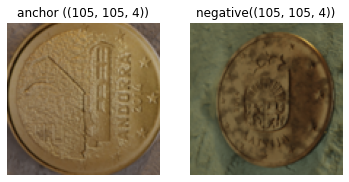

In [15]:
for image in data:
    anchor = image[0].numpy()
    validation = image[1].numpy()
    label = "positive" if sum(image[2].numpy()) == 5 else "negative"

    # show the images
    plt.subplot(1, 2, 1)
    plt.imshow(anchor)
    plt.axis('off')
    plt.title("anchor (" + str(image[0].shape) + ")")
    plt.subplot(1, 2, 2)
    plt.imshow(validation)
    plt.axis('off')
    plt.title(label + "(" + str(image[1].shape) + ")")
    plt.show()

    break

## Build model

In [ ]:
from src.models import make_embedding, make_siamese_model

In [16]:
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [18]:

embedding = make_embedding()

siamese_model = make_siamese_model(embedding)


In [19]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)  # 0.0001

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

test_batch = data.as_numpy_iterator()


In [25]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

In [26]:
from tensorflow.keras.metrics import Precision, Recall


def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
